## Задание 2. A/B тестирование
Эксперимент проходил с 2024-01-26 по 2024-02-01 включительно, задействованы 2 (тест) и 1 (контроль) группы.
1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравнить данные этими тестами. Посмотреть на распределения глазами. Почему тесты сработали именно так? 
3. Описать потенциальную ситуацию, когда такое изменение могло произойти.
4. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': '*',
'database':'*',
'user':'*',
'password':'*'
}
ALFA = 0.05

In [92]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240220.feed_actions 
WHERE toDate(time) between '2024-01-26' and '2024-02-01'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


<h2>Постановка гипотез</h2>
<h3>
<ul>
    <li> Нулевая гипотеза: средние CTR двух групп одинаковые. </li><br>
    <li> Альтернативная: средние CTR групп отличаются.</li>
</ul></h3>

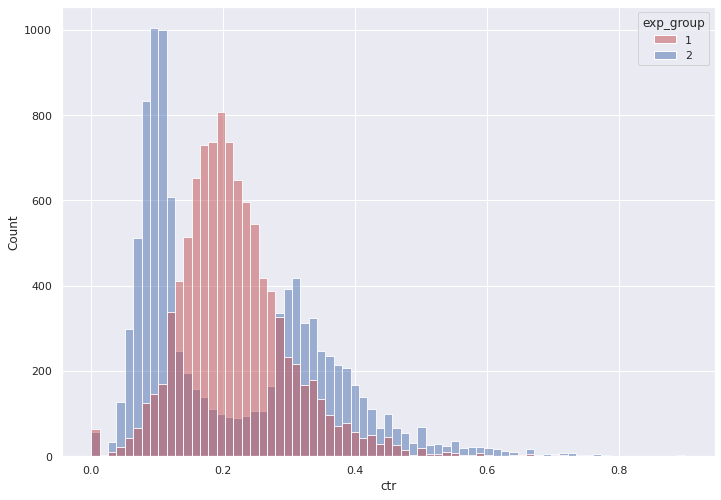

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
_, p_value_tt = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
print(f'Т-тест {p_value_tt}. Отличие {"не " if p_value_tt > ALFA else ""}прокрасилось')

Т-тест 0.685373331140751. Отличие не прокрасилось


In [24]:
_, p_value_mw = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr)
print(f'Манн-Уитни {p_value_mw}. Отличие {"не " if p_value_mw > ALFA else ""}прокрасилось')

Манн-Уитни 4.632205841806026e-45. Отличие прокрасилось


### Тесты сработали по-разному. Это может быть из-за того, что Т-тест требует нормального распределения, когда ctr группы 2 распределён не совсем нормально. Выражены два "горба". <br> Тест Манна-Уитни сработал предположительно лучше. Необходима проверка другими методами. Нет оснований отклонить нулевую гипотезу.

## Сглаженный CTR

In [48]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [60]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
df_combined = pd.concat([group1, group2])

<Axes: xlabel='smothed_ctr', ylabel='Count'>

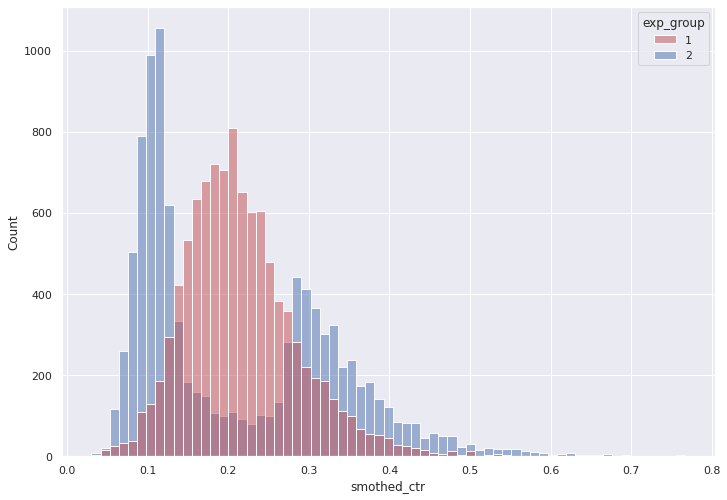

In [105]:
sns.histplot(
    data = df_combined, 
    x='smothed_ctr', 
    hue='exp_group', 
    palette = ['r', 'b'],
    alpha=0.5,
    kde=False
)

In [63]:
_, p_value_tt = stats.ttest_ind(df_combined[df_combined.exp_group == 1].smothed_ctr,
                df_combined[df_combined.exp_group == 2].smothed_ctr,
                equal_var=False)
print(f'Т-тест {p_value_tt}. Отличие {"не " if p_value_tt > ALFA else ""}прокрасилось')

Т-тест 0.05166679015318526. Отличие не прокрасилось


In [64]:
_, p_value_mw = stats.mannwhitneyu(df_combined[df_combined.exp_group == 1].smothed_ctr,
                df_combined[df_combined.exp_group == 2].smothed_ctr)
print(f'Манн-Уитни {p_value_mw}. Отличие {"не " if p_value_mw > ALFA else ""}прокрасилось')

Манн-Уитни 2.396534039374286e-50. Отличие прокрасилось


### При использовании сглаженного CTR получилась та же картина с тестами, что и в прошлый раз. Однако Т-тест вернул гораздо меньшее p-value, почти совпадающее с альфой эксперимента. <br> С определённым допущением (t-test чувствителен к нормальности распределения) можно отклонить нулевую гипотезу. Проведём дальнейшие тесты.

## Пуассоновский бустреп

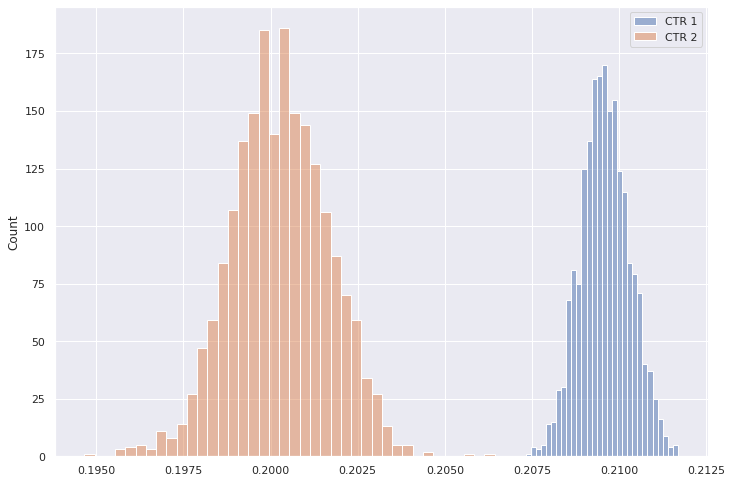

In [103]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, label='CTR 1', alpha=0.5)
sns.histplot(ctr2, label='CTR 2', alpha=0.5)
plt.legend()

<Axes: ylabel='Count'>

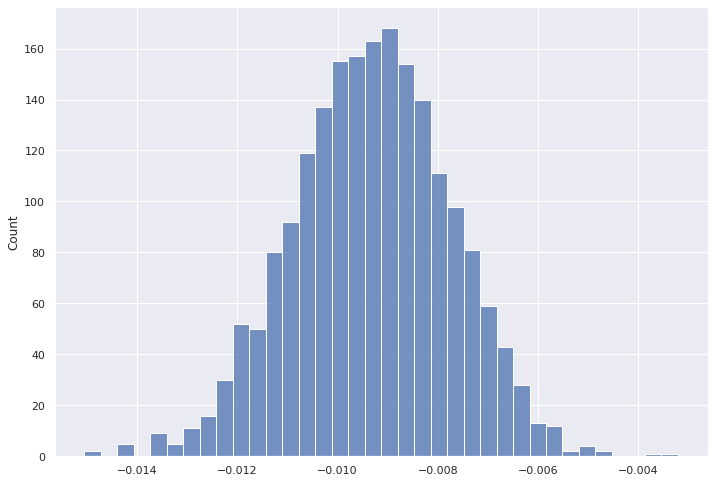

In [104]:
sns.histplot(ctr2 - ctr1)

### Разница между глобальными CTR (тест - контроль) в результате бустрепа оказалась отрицательной. 
#### Можно сделать вывод, что эффект в тестовой группе оказался больше отрицательным, чем положительным.

## Бакетное преобразование

In [82]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-01-26' and '2024-02-01'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_buckets = pandahouse.read_clickhouse(q, connection=connection)
df_buckets

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286
...,...,...,...,...
95,2,47,0.196808,0.428571
96,1,48,0.216369,0.320000
97,2,48,0.194780,0.400000
98,1,49,0.206288,0.333333


In [85]:
_, p_value_tt = stats.ttest_ind(df_buckets[df_buckets.exp_group == 1].bucket_ctr,
                df_buckets[df_buckets.exp_group == 2].bucket_ctr,
                equal_var=False)
print(f'Т-тест {p_value_tt}. Отличие {"не " if p_value_tt > ALFA else ""}прокрасилось')

Т-тест 4.592644937473873e-07. Отличие прокрасилось


In [87]:
_, p_value_mw = stats.mannwhitneyu(df_buckets[df_buckets.exp_group == 1].bucket_ctr,
                df_buckets[df_buckets.exp_group == 2].bucket_ctr,
                alternative = 'two-sided')
print(f'Манн-Уитни {p_value_mw}. Отличие {"не " if p_value_mw > ALFA else ""}прокрасилось')

Манн-Уитни 2.6576427804010095e-07. Отличие прокрасилось


### Результаты тестов поверх бакетного преобразования прокрасились оба. То есть мы можем отклонить нулевую гипотезу в пользу альтернативной. CTR двух групп отличается.

# Вывод
<h4>Анализируя первую диаграмму распределения CTR в тестовой группе есть несколько возможных вариантов почему так могло произойти:
    <ul>
    <li> Новый алгоритм рекомендаций часть пользователей встретила положительно, а часть отрицательно.</li><br>
    <li> Пользователи в тестовой группе в те же даты принимали участие в другом тестировании в составе разных групп с функционалом, который косвенно или прямо влиял на CTR.</li>
    </ul>
Суммируя результаты всех проведённых тестов и принимая во внимание отрицательную разницу метрики в Пуассоновском бутстрепе можно сделать следующий вывод: <br> Статистически значимые отличия в группах есть, но эффект от нового алгоритма в целом снизил ключевую метрику для тестовой группы. <br> Я бы не рекомендовал выкатывать функционал на новых пользователей.</h4>